# Introduction
This notebook implements Logistic Regression with Gradient Descent. 

- Algorithms: Logistic Regression
- DataSets:   "logistic_regression" 
- Video: To Be Added.


In [6]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.decomposition import PCA

class TargetFunction():
    def __init__(self, function, string_representation): 
        self.function = function
        self.string_representation = string_representation
        
    def __str__(self):
        return self.string_representation
    

class DataSet:
    
    # Potential features:
    # - Add parameter that allows to decide if bias should be encoded in data.
    # - Add parameter that allows to decide if labels should be {0, 1} or {-1, +1}
    def __init__(self, name, n=100, d=2, var=0.8, means=np.array([[8,2], [2,8]]), xlim=[0,10], ylim=[0,10]):
        self.xlim = xlim
        self.ylim = ylim
        
        self.name = name
        if name == "perceptron": 
            self.X, self.y = self.make_classification(n, 2, means = np.array([[2,4], [8,5]]))
        elif name == "pocket":
            self.X, self.y = self.make_classification(n, 2, means = np.array([[3,5], [8,5]]))
        elif name == "linear_regression":
            self.X, self.y, self.target_function = self.make_regression(n, d)
        elif name == "linear_classification":
            pass
        elif name == "breast_cancer":
            self.X, self.y = sklearn.datasets.load_breast_cancer(return_X_y=True)
            n, d = self.X.shape
            self.X = np.concatenate((np.ones(n).reshape(n, 1), self.X), axis=1)
            self.y = 2*self.y-1
        elif name == "breast_cancer_2d": 
            X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
            self.X, self.y = self.pca_2d(X, y)
            
        elif name == "logistic_regression":
            self.X, self.y = self.make_classification(n, 2, means = means, variance=var)
        elif name == "not_linearly_seperable":
            self.X, self.y = non_linear_circle(n, 0.2)
            
    def pca_2d(self, X, y): 
        n, _ = X.shape

        pca = PCA(n_components=2)
        pca.fit(X)

        X = X @ pca.components_[:2].T
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        self.xlim = [np.min(X[:,1]), np.max(X[:,1])]
        self.ylim = [np.min(X[:,2]), np.max(X[:,2])]
        
        return X, y*2-1 # change from {0, 1} to {-1, +1}
            

    def non_linear_circle(n, variance=0.2):
        ''' Generate a binary classification problem that is not linearly seperable (circle). '''
        r_class0 = 0.3
        r_class1 = 2

        # for each point, normally distribute around radius and uniformly pick an angle. 
        angles = np.random.rand(n)*2*np.pi
        noisy_r_0 = np.random.normal(loc=r_class0, scale=variance, size=n//2)
        noisy_r_1 = np.random.normal(loc=r_class1, scale=variance, size=n//2)


        # compute (x,y) points from polar coordinates (r, angle). 
        X_0 = noisy_r_0 * np.cos(angles[:n//2])
        y_0 = noisy_r_0 * np.sin(angles[:n//2])
        X_1 = noisy_r_1 * np.cos(angles[n//2:])
        y_1 = noisy_r_1 * np.sin(angles[n//2:])

        X_0 = np.concatenate((np.ones(n//2).reshape(n//2, 1), X_0.reshape(n//2, 1), y_0.reshape(n//2, 1)), axis=1)
        X_1 = np.concatenate((np.ones(n//2).reshape(n//2, 1), X_1.reshape(n//2, 1), y_1.reshape(n//2, 1)), axis=1)
        X = np.concatenate((X_0, X_1), axis=0)
        y = np.concatenate((np.zeros(n//2), np.ones(n//2)))

        perm = np.random.permutation(n)

        X = X[perm]
        y = y[perm]
        return X, y
        
    def make_regression(self, n, d):
        """ For now assumes d=2, make data normally distributed around line. """
        
        if d == 2:
            # Generate normally distributed noise that displaces points from line. 
            noise_variance = 0.5
            normal_distributed_noise = np.random.normal(loc=0, scale=noise_variance, size=n)

            # Generate random line f(x)=ax+b such that points normally distributed around line will 
            # have high probability of being inside plot. 
            b = np.random.rand(1)*5+2 # Let 'b' be in [4, 6] uniform random
            sign = np.random.choice([-1, +1])
            a = sign* np.random.rand(1)/10*4 # let 'a' be in [-4/10+noise_var, 4/10-noise_var] so all data are in uniform 10,10 box

            target_function = TargetFunction(lambda x: a*x+b, str(round(a[0], 2)) + "*x+" + str(round(b[0], 2)))
            target_function.w = [b, a]

            xs = np.ones((n, 2)) 
            xs[:, 1] = np.random.rand(n)*10 

            ys = target_function.function(xs[:, 1]) + normal_distributed_noise

            return xs, ys, target_function
        else:
            # Generate weight vector
            w = np.random.rand(d)
            
            noise_variance = 0.05
            normal_distributed_noise = np.random.normal(loc=0, scale=noise_variance, size=n)
            
            X = np.random.rand(n, d)
            y = X @ w + normal_distributed_noise
            
            return X, y, None
        
        

    def make_classification(self, n, d, means=None, num_classes=2, linear_seperable=False, variance=0.8):
        """ Creates data for a 'num_classes' classification problem. All points are generated in a 
        cube [0, 2]^d. Each class is generated as a normal distribution N(µ, 1) around a 
        randomly generated mean. 

        """
        # Generate num_classes means
        if means is None: 
            means = np.random.rand(num_classes, d)*10
        
        # Initialize data matrix and labels array
        # Encode 1's in first dimension
        X = np.ones((n, d+1))
        y = np.zeros(n, dtype=np.int32)

        for i in range(n):
            y[i] = np.random.choice(num_classes)
            X[i, 1:d+1] = np.random.normal(loc=means[y[i]], scale=variance)

        # Have labels be {-1, +1}
        y = y*2-1
            
        return X, y
    
    
    def plot(self):
        """ Assumes the data is 2d and plots it. Throws exception if data isn't 2d (with bias encoded). 
        
        """
        n, d = self.X.shape
        assert d == 3, "Data needs to be 2d (with bias encoded) to be plotted."
        
        if set(self.y) != {-1, +1}: self.y = self.y*2-1
        
        X_class_0 = self.X[self.y == -1]
        X_class_1 = self.X[self.y == 1]
        
        fig, ax_data = plt.subplots(1, 1, figsize=(4, 4))
        
        ax_data.set_title("Dataset: " + self.name)
        ax_data.set_xlabel("X dimension of data")
        ax_data.set_ylabel("Y dimension of data")
        ax_data.set_xlim(self.xlim[0], self.xlim[1])
        ax_data.set_ylim(self.ylim[0], self.ylim[1])
        ax_data.plot(X_class_0[:,1], X_class_0[:,2], 'go')
        ax_data.plot(X_class_1[:,1], X_class_1[:,2], 'bx')
        fig.canvas.draw()
        
    def plot_regression(self):
        n, d = self.X.shape
        #assert d == 2, "Data needs to be 2d (with bias encoded) to be plotted."
        
        plt.title("Dataset: " + self.name + ", Target Function: " + str(self.target_function))
        plt.xlabel("X dimension of data")
        plt.ylabel("Y dimension of data")
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        plt.plot(self.X[:,1], self.y, 'go')
        plt.show()




# Logistic Regression
The hypothesis set for logistic regression is

$$ H = \{ \sigma(w^T x) \mid w\in R^{d+1}\} $$

Given data $D=\{(x_1,y_1),...,(x_N, y_N)\}$ we want to minimize the following error function

$$E_{in}(h)=\sum_{i=1}^N...$$

Notice that any hypothesis $h(x)=\sigma(w^Tx)\in H$ is described exactly by is weights $w\in R^{d+1}$. Our goal is to find weights $w$ such that we minimize the in-sample error $E_{in}(w)$. 

Unfortunately, for Logistic Regression we do not have a formula that computes the optimal weights. The gradient can be found [1] to be 

$$\nabla_w E_{in}(w)=..$$

In the code below we use this as a fact. 

# Code: Logistic Regression

<IPython.core.display.Javascript object>


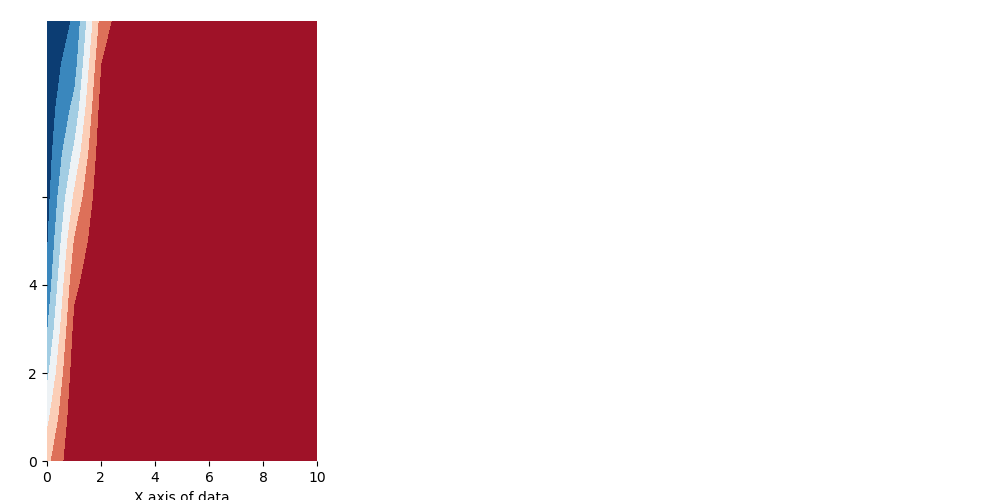

KeyboardInterrupt: 

In [7]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

class LogisticRegression:
    
    def __init__(self, visualize=False, sleep=0.0):
        self.visualize = visualize
        
        if self.visualize: 
            self.fig, (self.ax_data, self.ax_error, self.ax_error_01) = plt.subplots(1, 3, figsize=(10, 5))
            self.errors = []   
            self.errors_01 = []
            self.sleep = sleep
            self.fig.tight_layout()
    
    def fit(self, X, y, rounds, learning_rate):
        N, d = X.shape
        
        # Initialize weights randomly
        self.w = np.random.rand(d)
        
        # Take 'rounds' steps in the direction of the negative gradient
        for i in range(rounds):
            # Compute Gradient
            gradient = self.gradient(X, y)
            
            # Update weights
            self.w = self.w - learning_rate * gradient
            
            # Visualize if enabled. 
            if self.visualize: self.do_visualize(X, y)
      
    
    def sigmoid(self, x):
        return 1/(1+np.exp(x))
    
    def gradient(self, X, y): 
        return X.T @ (y - self.sigmoid(X @ self.w))
    
    def predict(self, X):
        return self.sigmoid(X @ self.w)
    
    def error(self, X, y):
        N, d = X.shape
        
        # Compute the inner product vector
        Xw = X @ self.w
        
        # Compute each part of the sum
        Xw_1 = np.log(self.sigmoid(Xw[y==1]))
        Xw_0 = np.log(self.sigmoid(1-Xw[y==0]))
        
        return - 1/N*(np.sum(Xw_1) + np.sum(Xw_0))
    
    def error_01(self, X, y):
        ''' Compute probability of each point and assign most likely class, then
        compute zero-one loss. '''
        pred = self.predict(X)
        hard_assign = (pred >= 0.5)
        accuracy = np.mean(hard_assign == y) 
        return 1 - accuracy
    
    
    def do_visualize(self, X, y):
        # Compute error and append to list
        self.errors.append(self.error(X, y))
        self.errors_01.append(self.error_01(X, y))
        
        self.ax_error.cla()
        self.ax_error.plot(range(1, len(self.errors) +1), self.errors, '-b')
        self.ax_error.set_xlabel("Iterations")
        self.ax_error.set_ylabel("Error")
        self.ax_error.set_title("Cross Entropy Loss")
        
        self.ax_error_01.cla()
        self.ax_error_01.plot(range(1, len(self.errors) +1), self.errors_01, '-g')
        self.ax_error_01.set_ylim(0, 1)
        self.ax_error_01.set_xlabel("Iterations")
        self.ax_error_01.set_ylabel("Error")
        self.ax_error_01.set_title("0-1 Classification Error")
        
        self.ax_data.cla()
        
        self.ax_data.set_xlabel("X axis of data")
        self.ax_data.set_ylabel("Y axis of data")
        self.ax_data.set_title("Logistic Regression")
        
        # plot data
        X_0 = X[y==0]
        X_1 = X[y==1]
        self.ax_data.plot(X_0[:,1], X_0[:,2], 'go')
        self.ax_data.plot(X_1[:,1], X_1[:,2], 'bo')
        self.ax_data.set_xlim(0,10)
        self.ax_data.set_ylim(0,10)
        
        # Draw probabilities
        grid_points = np.array([(1, i, j) for i in range(11) for j in range(11)])
        pred = logreg.predict(grid_points).reshape((11, 11))
        c = self.ax_data.contourf(np.arange(11), np.arange(11), pred, vmin=0, vmax=1, cmap="RdBu")
        
        # draw proababilities
        self.fig.canvas.draw()
        time.sleep(self.sleep)
    

# make harder dataset
data = DataSet("logistic_regression", n=100, var=3, means=np.array([[2,8], [8,2]]))
data.y = (data.y+1)//2

logreg = LogisticRegression(visualize=True)
logreg.fit(data.X, data.y, rounds=1000, learning_rate=0.01)

pred = logreg.predict(data.X)

print(logreg.error_01(data.X, data.y))

# (todo) Math: Error measure
see LFD pages .

# (todo) Experiment: Breast Cancer dataset